We now use observatio covariance =1.0 and 4.0 and gap= 0.01  

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
def shorten(arr, factor=10):
    arr_shape = list(arr.shape)
    arr_shape[0] = int(arr_shape[0]/factor)
    new_arr = np.zeros(arr_shape)
    for i in range(arr_shape[0]):
        new_arr[i] = arr[i*factor]
    return new_arr

In [55]:
# Change here for different observation gap and observation covariance parameter
mu=0.9
ob_gap=0.01

#factor in time
#Partial or full observation
ob_dim=1
ecov=2.0 
alpha=1.0
ebias=6.0   
l_scale=0
factor_=int(ob_gap/0.01)
k=5
N=25

#load the state
data_path='/home/shashank/Documents/enkf_for_clv2/data/L63_assim'
os.chdir(data_path)

#load the state
state=np.load('Multiple_trajectories_N=1_gap=0.01_ti=0.0_tf=350.0_dt_0.01_dt_solver=0.002.npy')

os.chdir(data_path+'/ob{}'.format(k)) 
obs=np.load('ob{}_gap_{}_H1__mu={}_obs_cov1.npy'.format(k,ob_gap,mu))

#Go inside the data folder......................................
folder_label='ebias={}_ecov={}_obs={}_ens={}_mu={}_gap={}_alpha={}_loc=none_r={}'.format(ebias, ecov,ob_dim,N,mu,ob_gap,alpha,l_scale)
print(os.getcwd())
os.chdir(folder_label)

#Load data....
a_ens=np.load('filtered_ens.npy') #ens has shape:=[time steps,system dimension,ensemble number]
a_mean=np.load('filtered_mean.npy')

/home/shashank/Documents/enkf_for_clv2/data/L63_assim/ob5


In [56]:
time=ob_gap*np.arange(a_mean.shape[0])

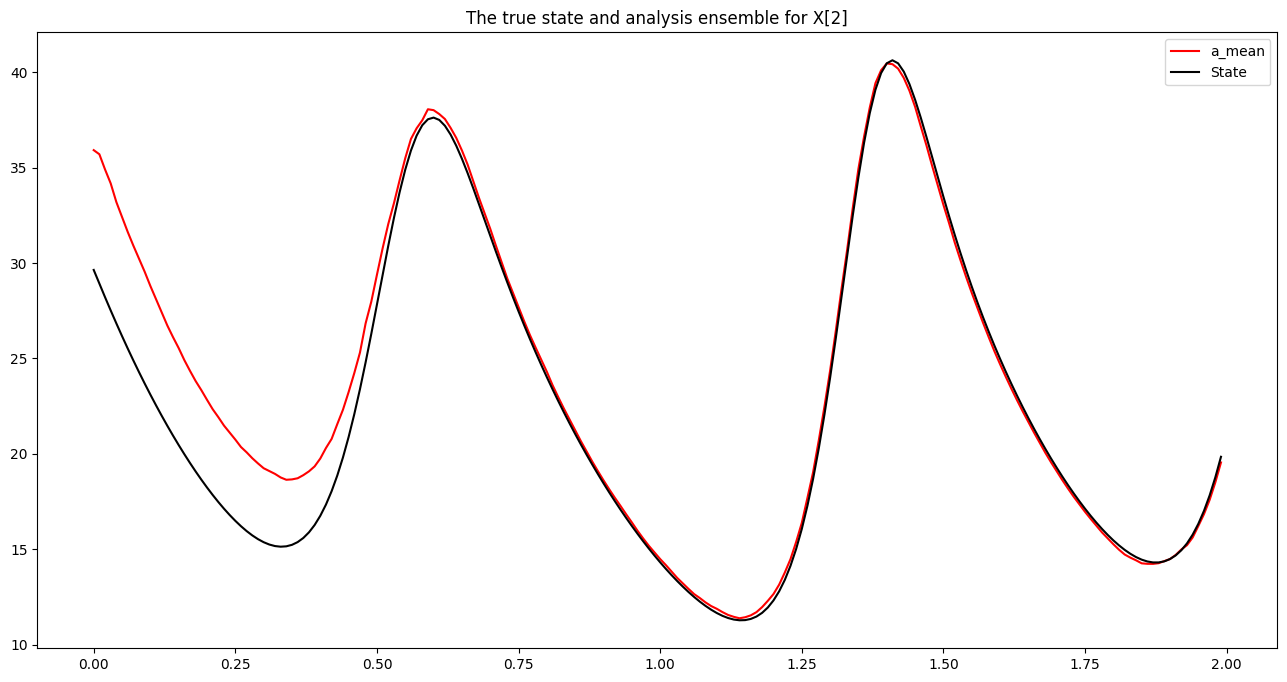

In [70]:
plt.figure(figsize=(16,8))
# Start time and end time chosen to view a part of time series
t_start=0
t_stop=200
# component to view
comp_=2
#plt.plot(time[t_start:t_stop],a_ens[t_start:t_stop,comp_],linestyle='solid',alpha=0.5) 
plt.plot(time[t_start:t_stop],a_mean[t_start:t_stop,comp_],c='r',alpha=1,label='a_mean')

#plt.plot(time[t_start:t_stop],f_mean[t_start:t_stop,comp_],c='blue',alpha=0.5,label='f_mean')
plt.plot(time[t_start:t_stop],state[t_start:t_stop,comp_],c='black',label='State')
if (comp_%2!=0):
    plt.errorbar(time[t_start:t_stop], obs[t_start:t_stop,int(comp_/2)], yerr=np.sqrt(mu), fmt='o',alpha=1, color='indigo',
                    ecolor='saddlebrown', elinewidth=1, markersize=2)
#plt.scatter(time[t_start:t_stop],obs[t_start:t_stop,comp_-1],c='r',marker='.',label='obs')
    
plt.legend()
plt.title(r'The true state and analysis ensemble for X[{}]'.format(comp_))
#plt.xticks(time[t_start:t_stop],fontsize=12)
plt.legend(frameon='True')

## L2-error over time

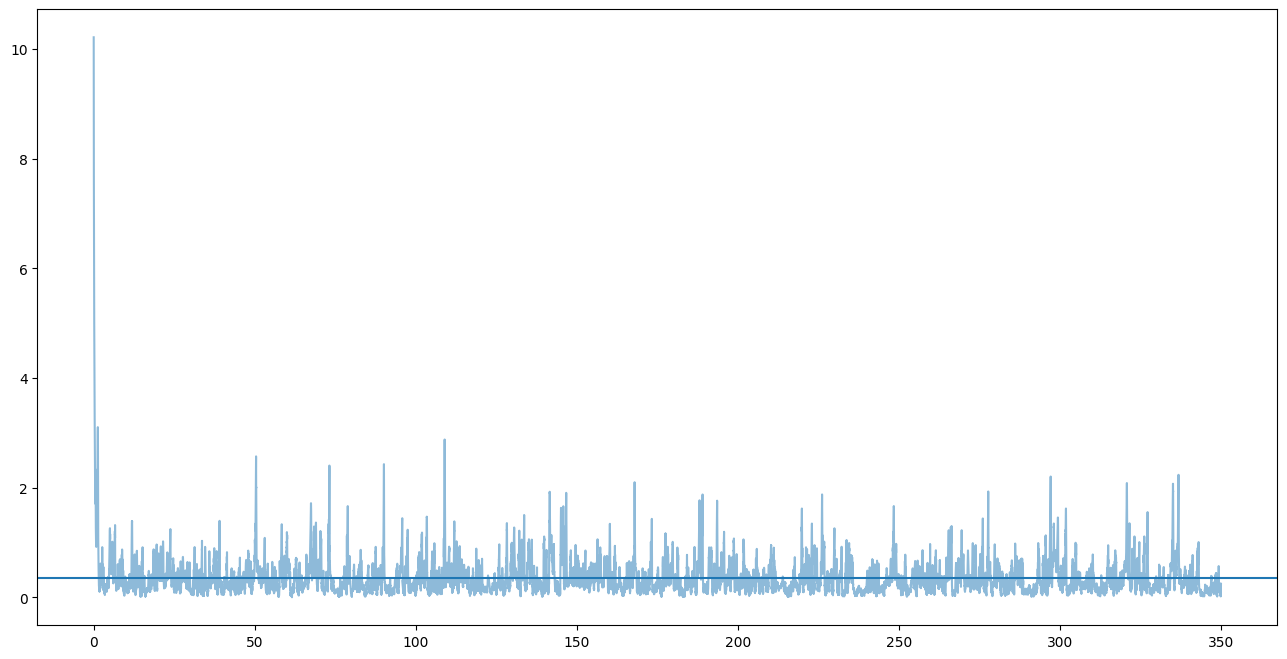

In [58]:
plt.figure(figsize=(16,8))
t_start=0
t_stop=35000
plt.plot(time[t_start:t_stop],np.sqrt(np.sum((state[t_start:t_stop]-a_mean[t_start:t_stop])**2,axis=1)),linestyle='solid',alpha=0.5)
plt.axhline(np.mean(np.sqrt(np.sum((state[t_start:t_stop]-a_mean[t_start:t_stop])**2,axis=1))))
#plt.plot(time,fro_norm,label='Gap={}'.format(ob_gap))
#plt.savefig('/tmp/fig2.png')

## Error in the estimated jacobian

In [52]:
from jax import grad,jacfwd,jacrev,linearize,vmap,partial,vjp,jvp,jit
import jax.numpy as jnp

In [53]:
# Error in Jacobian is the next important thing
rho = 28.0
sigma = 10.0
beta = 8.0/3.0

#We have the rhs of an ode below
def L63(x):
    "Function to be used for compuation of ode in scipy.integrate.solve_ivp"
    return jnp.array([sigma*(x[1]-x[0]),x[0]*(rho-x[2])-x[1],x[0]*x[1]-beta*x[2]])

Jac_f=jit(jacfwd(L63))

In [54]:
fro_norm=np.zeros(len(time))
for i in range(len(time)):
    J_t_state=Jac_f(state[i])
    J_t_analysis=Jac_f(a_mean[i])
    fro_norm[i]=np.linalg.norm(J_t_state-J_t_analysis,ord='fro')    

Text(0.5, 1.0, 'Error in Jacobian')

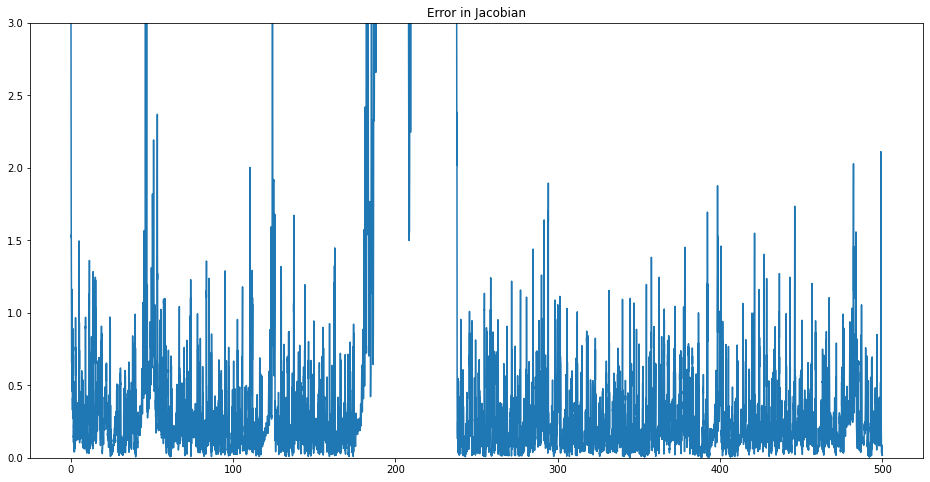

In [65]:
plt.figure(figsize=(16,8))
#plt.yscale('log')
plt.ylim(0,3)
plt.plot(time,fro_norm,label='Gap={}'.format(ob_gap))
plt.title('Error in Jacobian')

In [63]:
os.chdir('/home/shashank/Documents/Data Assimilation/ENKF_for_CLVs/data/L63_clvs/noisy_state/Analysis')
#np.save('frobenius_norm_gap={}.npy'.format(ob_gap),fro_norm.shape)
np.save('Analysis_mean_g={}_mu={}.npy'.format(ob_gap,mu),a_mean)
#np.save('Forecast_mean_g={}_mu={}.npy'.format(ob_gap,mu),f_mean)
#np.save('State_g={}_mu={}.npy'.format(ob_gap,mu),state)

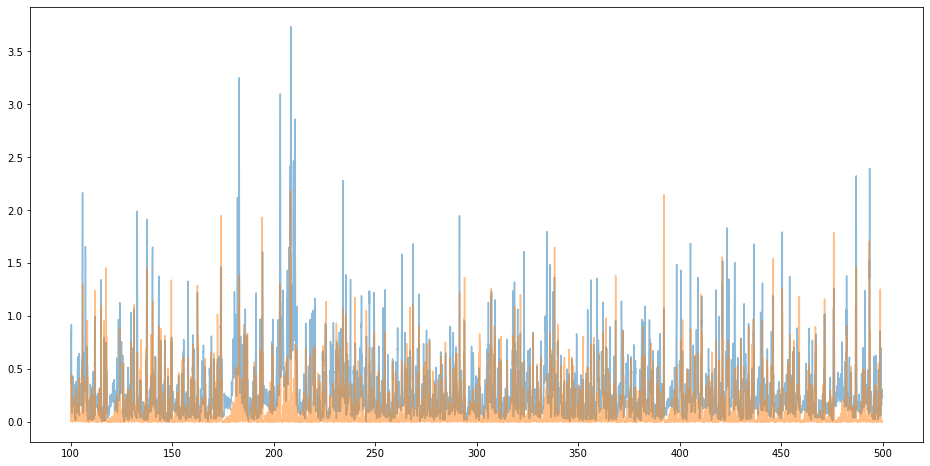

In [325]:
plt.figure(figsize=(16,8))
t_start=2000
t_stop=10000
plt.plot(time[t_start:t_stop],np.sqrt(np.sum((state[t_start:t_stop]-a_mean[t_start:t_stop])**2,axis=1)),linestyle='solid',alpha=0.5)
plt.plot(time[t_start:t_stop],np.sqrt(np.sum((f_mean[t_start:t_stop]-a_mean[t_start:t_stop])**2,axis=1)),linestyle='solid',alpha=0.5)


In [ ]:
# ob 5 , all instances use mu=1.0, whatever the true mu may be.
# ob 4, all instances use assumed mu = true mu.